<a href="https://colab.research.google.com/github/neha-sharma4/ML_Lab/blob/main/MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import joblib

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_all, y_all = mnist['data'], mnist['target']

# 2. Filter for digits '0' and '1' only
mask = (y_all == '0') | (y_all == '1')
X = X_all[mask].astype(np.float32)
y = (y_all[mask] == '1').astype(int)
print("Total samples (0 vs 1):", X.shape[0])

Total samples (0 vs 1): 14780


In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1764706, random_state=42, stratify=y_temp
)  # 0.17647*0.85 ≈ 0.15 -> yields approx 70/15/15 split

print("Train / Val / Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Train / Val / Test sizes: 10345 2218 2217


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [6]:
lr = LogisticRegression(
    penalty='l2', solver='liblinear', C=1.0, max_iter=1000, random_state=42
)
lr.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [7]:
y_val_pred = lr.predict(X_val_scaled)
y_val_proba = lr.predict_proba(X_val_scaled)[:, 1]

print("Validation metrics (baseline):")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=4))


Validation metrics (baseline):
Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1036
           1     1.0000    1.0000    1.0000      1182

    accuracy                         1.0000      2218
   macro avg     1.0000    1.0000    1.0000      2218
weighted avg     1.0000    1.0000    1.0000      2218



In [8]:
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC (val):", roc_auc)


ROC AUC (val): 1.0


In [9]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)
print("Best params:", grid.best_params_, "Best CV f1:", grid.best_score_)

best_lr = grid.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'C': 0.1} Best CV f1: 0.9989109048568796


In [10]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = best_lr.predict(X_test_scaled)
y_test_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

print("Test metrics (best model):")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
print("ROC AUC (test):", auc(fpr_test, tpr_test))


Test metrics (best model):
Accuracy: 0.9986468200270636
              precision    recall  f1-score   support

           0     0.9981    0.9990    0.9986      1035
           1     0.9992    0.9983    0.9987      1182

    accuracy                         0.9986      2217
   macro avg     0.9986    0.9987    0.9986      2217
weighted avg     0.9986    0.9986    0.9986      2217

Confusion matrix:
 [[1034    1]
 [   2 1180]]
ROC AUC (test): 0.9999983651716161


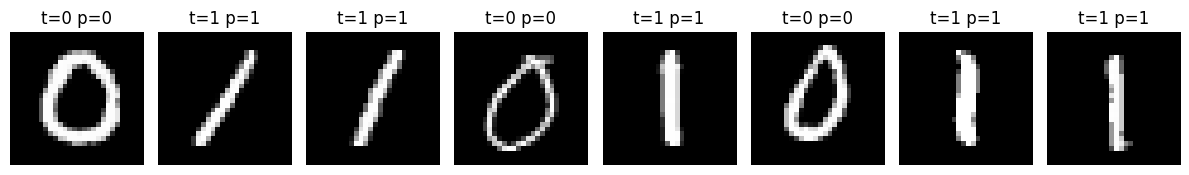

In [11]:
def show_samples(X_raw, y_true, y_pred, num=8):
    plt.figure(figsize=(12, 2))
    for i in range(num):
        idx = i
        plt.subplot(1, num, i+1)
        plt.imshow(X_raw[idx].reshape(28, 28), cmap='gray')
        plt.title(f"t={y_true[idx]} p={y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(X_test, y_test, y_test_pred, num=8)


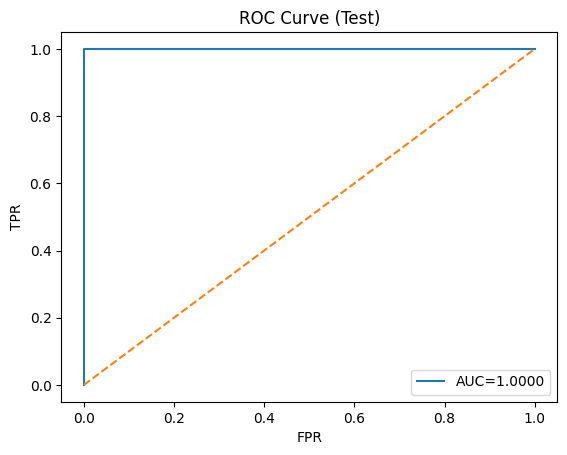

In [12]:
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'AUC={auc(fpr_test, tpr_test):.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (Test)')
plt.legend()
plt.show()


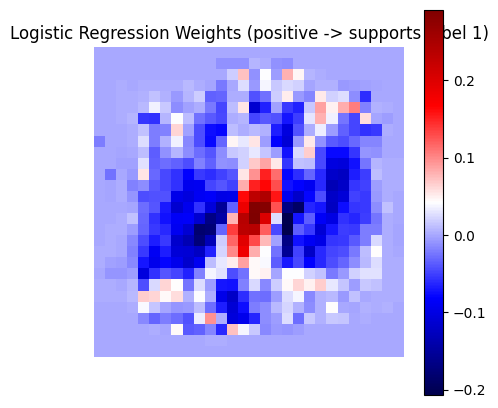

In [13]:
weights_img = best_lr.coef_.reshape(28, 28)
plt.figure(figsize=(5,5))
plt.imshow(weights_img, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.title('Logistic Regression Weights (positive -> supports label 1)')
plt.axis('off')
plt.show()


In [14]:
joblib.dump({'scaler': scaler, 'model': best_lr}, 'mnist_01_logreg.joblib')
print("Saved model as mnist_01_logreg.joblib")


Saved model as mnist_01_logreg.joblib
